# Neutron-burst Nucleosynthesis
This notebook applies analytic solutions to the neutron-burst nucleosynthesis problem. The user defines the burst network, builds up contributions of one species to another during the burst, and then uses those contributions to compute the abundance changes during a burst.  With such solutions available, the user can look at a distribution of burst exposures and compare results to user-supplied cosmochemical data.

# Preliminaries 
We begin by importing the necessary libraries and defining key functions.

In [1]:
import sys, subprocess, pkg_resources
import os, io, requests
required = {'numpy', 'wnutils', 'wnnet', 'matplotlib', 'ipywidgets', 'wnpoly'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import wnnet as wn 
from scipy.integrate import solve_ivp
import scipy.integrate as integrate
import wnutils.xml as wx
import wnpoly as wp
import matplotlib.pyplot as plt
from statistics import geometric_mean
import ipywidgets as widgets
from ipywidgets import interact, fixed
import numpy as np
import math
from IPython.display import display, Math

Next, define a routine to compute the neutron capture cross sections using [wnnet](https://readthedocs.io/wnnet).

In [2]:
def get_sigs(net, t9):
    induced_reac_xpath = "[reactant = 'n' and product = 'gamma']"
    reacs = net.compute_rates(t9, reac_xpath = induced_reac_xpath)
    rates = []
    for key, values in list(reacs.items()):
        rates.append(values[0])
    
    ordered_dict = {}

    for sp in species:
        for key, value in net.get_reactions(reac_xpath = induced_reac_xpath).items():
            if sp in value.reactants:
                ordered_dict[sp] = reacs[key][0]
            
    T = t9 * 10**9
    k = wn.consts.consts.GSL_CONST_CGS_BOLTZMANN
    N_A = wn.consts.consts.GSL_CONST_NUM_AVOGADRO
    m_n = wn.consts.consts.GSL_CONST_CGS_MASS_NEUTRON
    v_T = np.sqrt((2*k*T)/m_n)
    sigs_array = []
    for key, value in ordered_dict.items():
        sigs_array.append(1000*value/(v_T*N_A*wn.consts.consts.GSL_CONST_CGSM_BARN))
        
    return sigs_array

Now define a routine to retrieve the solar abundances and mass numbers for a particular set of species.

In [3]:
def get_abunds(solar_xml, my_species):
    solar_data = solar_xml.get_zone_data()
    x_solar = solar_data["0"]["mass fractions"]

    a = []
    d = {}

    for isotope in my_species:
        tup = solar_xml.get_z_a_state_from_nuclide_name(isotope)
        s_tup = (isotope, tup[0], tup[1])
        if s_tup in x_solar:
            a.append(s_tup[2])
            d[s_tup[0]] = x_solar[s_tup] / tup[1]
        else:
            a.append(s_tup[2])
            d[s_tup[0]] = 0
            
    return a, d

For the analytic solution to the linear acyclic reaction network relevant in this problem, we need the geometric mean for all paths and the coefficients of the bell polynomials corresponding to the cross sections in the path. Here we define a function to return these values.

In [4]:
def get_variables(sigs_array, j):
    s = wp.symm.Complete()
    h = s.compute_normalized(sigs_array, j) 
    b = wp.bell.Bell()
    x = b.invert(h)
    if len(sigs_array)>1:
        gmean = geometric_mean(sigs_array[0:len(sigs_array)-1])
    else:
        gmean = 1
    return [len(sigs_array), gmean, x]

Define analytic and numeric functions for the computation of the contribution of one species to another in the neutron burst.

In [5]:
def g_numerical(t, y, sigmas):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigmas[0]*y[0]
    for i in range(1, N):
        result[i] = sigmas[i-1]*y[i-1] - sigmas[i]*y[i]
    return result

def g_analytic(tau, tup):
    result = 0
    for n in range(len(tup[2])):
        result += tup[2][n] * np.power(-tau, n) / math.factorial(n)
    return np.power(tup[1] * tau, tup[0]-1) * np.exp(result) / math.factorial(tup[0]-1)

Define a routine to return the matrix holding the variable for analytic species contributions.

In [6]:
def compute_matrix(my_sig_array,  my_species):
    matrix = np.empty((len(my_species),len(my_species)), dtype = "object")

    for i in range(len(my_species)):
        for j in range(len(my_species)):
            if j<=i: 
                sigmas = my_sig_array[j:i+1]
                matrix[i,j] = get_variables(sigmas, 2)
            else:
                matrix[i,j] = 0
                
    return matrix

Define a routine to return the matrix of species contributions versus exposure.

In [7]:
def compute_gs(my_sig_array, taus, my_species):
    matrix = compute_matrix(my_sig_array, my_species)
    
    Gs = np.empty((len(my_species),len(my_species)), dtype = "object")
    
    for i in range(len(my_species)):
        for j in range(len(my_species)):
            if j<=i:
                Gs[i,j] = g_analytic(taus, matrix[i,j])
            else:
                Gs[i,j] = 0
                
    return Gs

Now define functions for integration over a distribution of exposures.

In [8]:
def Grho_integrand(tau, tup, dist):
    return g_analytic(tau, tup) * dist(tau)

def Grho_norm(tau, dist):
    return dist(tau)

# Retrieve data.
This section retrieves the network and solar abundances data for the calculation.

First retrieve the network data needed to compute neutron-capture cross sections.  The default is to download the data from [OSF](https://osf.io/kyhbs).  The commented line shows how to import network data from a user-supplied file (here called *example_net.xml*).

In [9]:
net = wn.net.Net(io.BytesIO(requests.get('https://osf.io/kyhbs/download').content))
#net = wn.net.Net("example_net.xml")

Next retrieve the solar abundances.  The default is to download the abundances from [Lodders (2003)](https://ui.adsabs.harvard.edu/abs/2003ApJ...591.1220L/abstract) from [OSF](https://osf.io/bd3xn/).  The commented line shows how to import data from a user-supplied file.

In [10]:
solar_xml = wx.Xml(io.BytesIO(requests.get("https://osf.io/j67qa/download").content))
#solar_xml = wx.Xml("example_solar.xml")

# Set the network and compute the cross sections.
This section sets the neutron-burst network. The isotopes defined must be of the same element and must have increasing consecutive mass number (this is a condition for a neutron burst network).  This secction also lets the user define the temperature and compute the appropriate neutron-capture cross sections.

Here define the network.  The default is a network of nickel isotopes.

In [39]:
species = ['ni58','ni59','ni60','ni61','ni62','ni63','ni64']

Define a $T_9$, the temperature for the neutron burst in billions of K.   The temperature during the neutron burst will be roughly constant, so defining a single temperature is a good approximation.

In [40]:
t9 = 0.7

Now compute and print out the neutron-capture cross sections for our neutron-burst network at the input temperature.  The cross sections have the units of inverse millibarns.

In [41]:
sigs_array = get_sigs(net, t9)

for i in range(len(sigs_array)):
    latex_name = solar_xml.get_latex_names([species[i]])[species[i]]
    sig_value = sigs_array[i]

    latex_str = f"$\sigma_n$({latex_name}) : {sig_value:.4f} $\, \\text{{mb}}$"

    display(Math(latex_str))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# The relative contribution - G
In the neutron burst, neutrons are released suddenly and are captured rapidly so that beta decays may be neglected.  A convenient evolutionary parameter, then, is the neutron exposure $\tau$, which is given by the expression

\begin{gather}
\tau = \int_0^\infty n_n(t) v_T(t) dt\notag
\end{gather}

where $n_n(t)$ is the neutron number density at time $t$ and $v_T(t)$ is the thermal velocity, also at time $t$.  The neutron exposure gives the number of neutrons crossing a square centimeter over the duration of the burst.

In the burst, a species with atomic number $Z$ and mass number $A'$ may capture one or more neutrons.  In this way, the initial abundance of that species contributes to the final abundance of another species with atomic number $Z$ and mass number $A$.  The quantity $G(Z, A, \tau; Z, A', 0)$ is the fraction of the initial abundance of species $(Z, A')$ that contributes to the final abundances of species $(Z, A)$ over exposure $\tau$.  For the linear, acyclic network in the present case, we may find:

\begin{gather}
G(Z,A,\tau;Z, A', 0) = \frac{(\sigma \tau)^{N-1}}{(N-1)!}\exp\Big({\sum_{j=1}^\infty x_j \frac{(-\tau)^j}{j!}}\Big)\notag
\end{gather}

The $\sigma$ is the geometric mean of the cross sections between $(Z,A')$ and $(Z,A)$, $N$ is the number of species in the chain from $(Z, A')$ to $(Z, A)$, $\tau$ is the exposure, and the $x_j$s are variables derived from Bell polynomials of the cross sections between $(Z, A')$ and $(Z,A)$. The Bell-polynomial-derived variables are computed using the [wnpoly](https://wnpoly.readthedocs.io) python package and the previously defined *get_variables* function. Note also that the function includes an infinite sum in the exponential.  The exact solution requires all those terms, but for the neutron burst, for which $\tau$ is typically less than one, inclusion of only two or three terms usually gives a sufficiently accurate result.

This cell computes $G(Z, A, \tau; Z, A', 0)$ both via the analytic solution above and a numerical integration of the network equations.  The numerical solution, if sufficiently accurate, may be thought of as the analytic solution including all terms in the infinite sum of the exponent.  The user chooses *sp1*, which is $(Z, A')$, *sp2*, which is $(Z, A)$, and $j_m$, which is the number of terms in the polynomial in the exponential part of $G(Z, A, \tau; Z, A', 0)$.  The cell prints out the $N$, $\sigma$, and $X_j$'s for the analytic solution.  It also plots the analytic versus numerical solution.  Increasing $j_m$ can improve the agreement between the analytic and numerical solutions, but $j_m = 2$ or $3$ is usually sufficient to give a good match.

interactive(children=(Dropdown(description='sp1', options=('ni58', 'ni59', 'ni60', 'ni61', 'ni62', 'ni63', 'ni…

<function __main__.compare(sp1, sp2, j_m)>

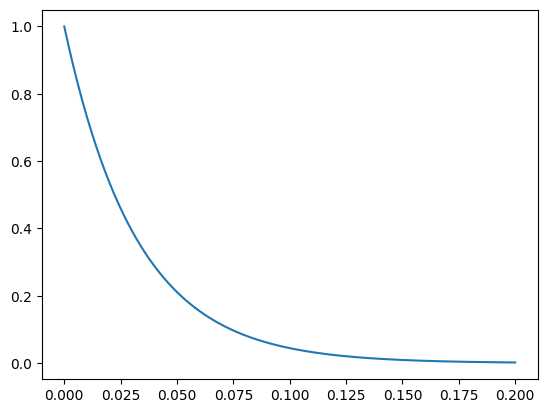

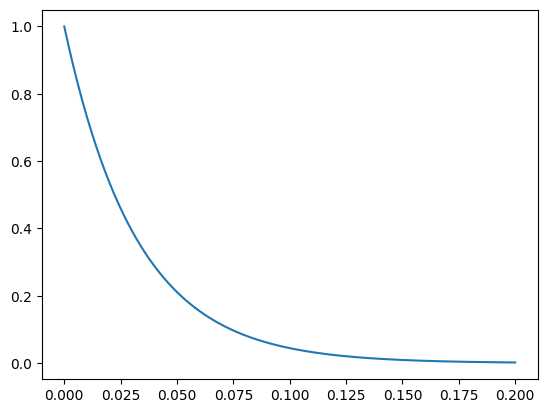

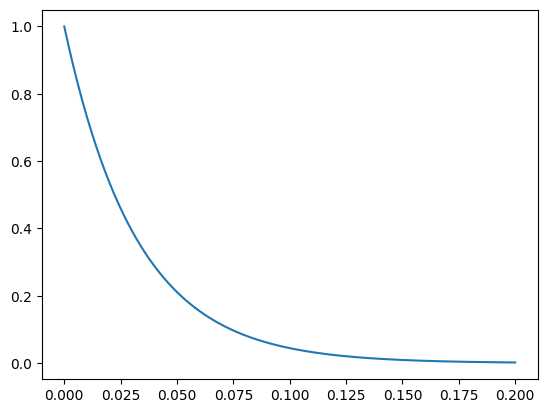

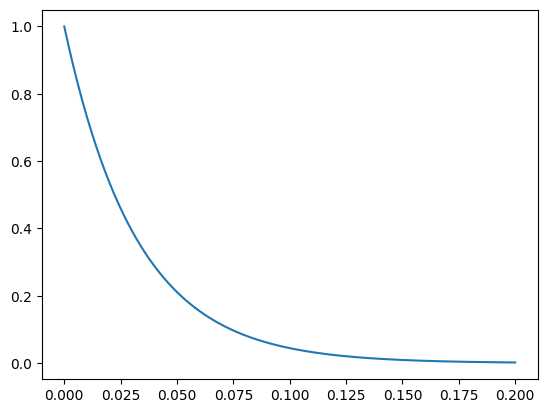

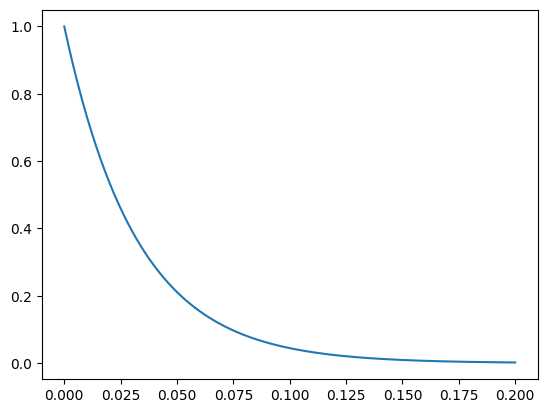

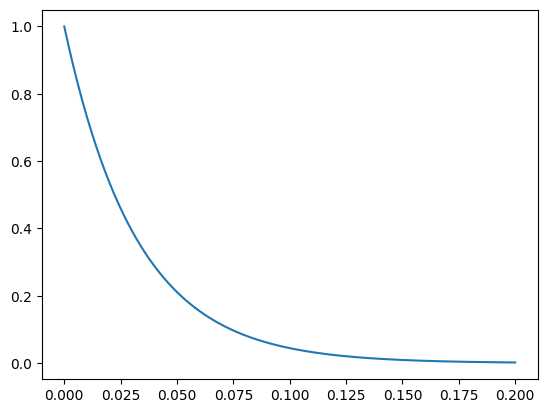

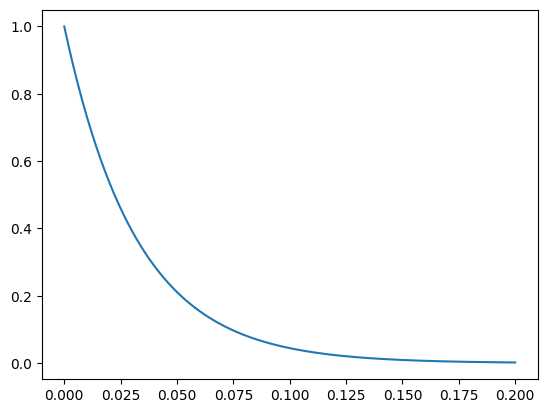

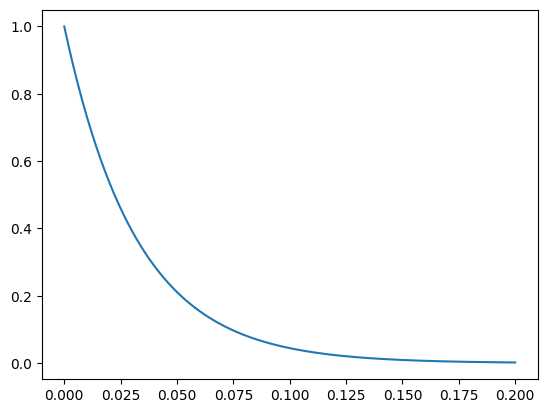

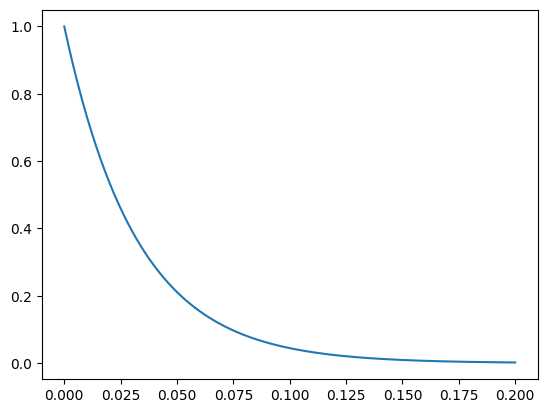

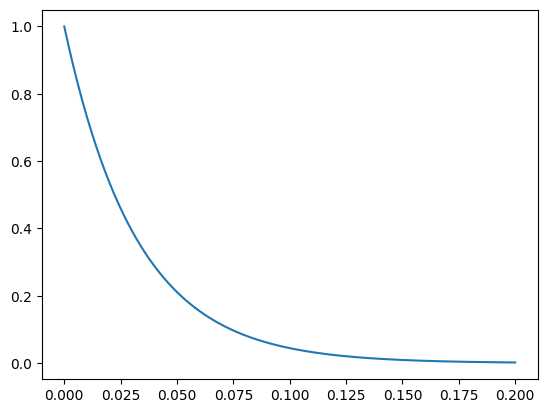

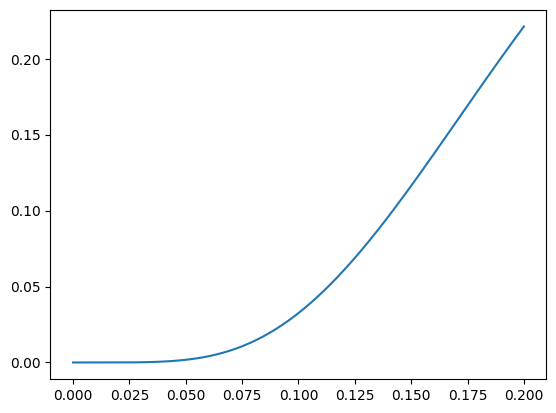

In [42]:
def compare(sp1, sp2, j_m):
    N = len(species[species.index(sp1):species.index(sp2)+1])
    sigs = sigs_array[species.index(sp1): species.index(sp2)+1]
    tup = get_variables(sigs, j_m) 
    print('******************************************************************************************')
    print("The variables required to compute the relative contribution of " + f"{sp1} to {sp2} are:\n")
    print(f"    N = {tup[0]}")
    print(f"    sigma = {tup[1]:.4f}")
    for j in range(1, len(tup[2])):
          print(f"    x_{j} = {tup[2][j]:.4f}")
    print('******************************************************************************************')
    abunds = np.zeros(N)
    abunds[0] = 1
    tau = np.linspace(0, .2, 30) 
    sol = solve_ivp(g_numerical, [tau[0], tau[len(tau)-1]], abunds, args = (sigs,), max_step = 0.001)
    plt.plot(sol.t, sol.y[-1], label = 'numerical')
    plt.plot(tau, g_analytic(tau,tup), 'o', label = 'analytic')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$G(\tau)$')
    plt.legend()
    
interact(compare, 
        sp1 = widgets.Dropdown(options = species),
        sp2 = widgets.Dropdown(options = species), 
        j_m = widgets.BoundedIntText(value = 2, min = 2, max = 50))

This cell computes the contributions of all lower-mass species to a given species.  This involves computing $G(Z, A, \tau; Z, A', 0)$ for all $A' \leq A$ in the network.  The user may vary the number of terms in the exponential polynomial ($j_m$).

In [52]:
def contributions(sp, j_m):
    index = species.index(sp)
    tau = np.linspace(0, 0.2, 100)
    G = np.empty(index+1, dtype = 'object')
    for i in range(index+1):
        sigs = sigs_array[i:index+1]
        G[i] = g_analytic(tau, get_variables(sigs, j_m))
    for i in range(len(G)):
        plt.plot(tau, G[i], label = solar_xml.get_latex_names([species[i]])[species[i]])
    plt.legend()
    plt.ylabel(r'$G(\tau)$')
    plt.xlabel(r'$\tau$')
    plt.show()

interact(contributions, 
        sp = widgets.Dropdown(options = species), 
        j_m = widgets.BoundedIntText(value = 2, min = 2, max = 30))

interactive(children=(Dropdown(description='sp', options=('ni58', 'ni59', 'ni60', 'ni61', 'ni62', 'ni63', 'ni6…

<function __main__.contributions(sp, j_m)>

# The abundances - Y
With a reliable analytic solution available for the exposure range we are considering, we can look at the abundances of species in the analytic solution.  The abundance of species $(Z,A)$, that is, $Y(Z,A,\tau)$, is given by the contribution of all species along the path multiplied by their relavent initial abundance $Y(Z,A',0)$:
\begin{gather}
Y(Z,A,\tau) = \sum_{A'\leq A} G(Z,A,\tau;Z,A',0)\,Y(Z,A',0)
\end{gather}


First, we retrieve the solar abundances for the species in our network.

In [44]:
a, y0 = get_abunds(solar_xml, species)
y0_list = []
for sp in species:
    y0_list.append(y0[sp])
y0_array = np.array(y0_list)

Define an array of exposures and compute Gs, the analytic contributions of species over that array.  Gs is a matrix.  Each element of Gs is an array of contributions of the species indexed by the matrix column number to the species indexed by the matrix row number.  The array for each element gives the contributions as a function of exposure.

In [45]:
tau = np.linspace(0, 0.3, 100)
Gs = compute_gs(sigs_array, tau, species)

Now compute and plot the abundances.

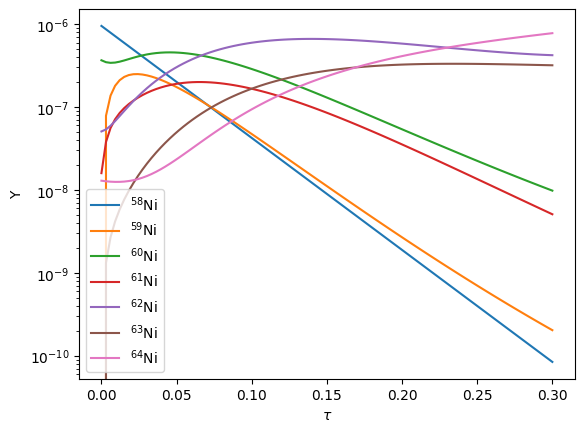

In [46]:
abundances = np.dot(Gs, y0_array)

for i in range(len(species)):
    plt.plot(tau,abundances[i], label = solar_xml.get_latex_names([species[i]])[species[i]])
    
plt.legend()
plt.ylabel('Y')
plt.xlabel(r'$\tau$')
plt.yscale('log')
plt.show()

It is also instructive to consider the contribution of each species to the abundance of a given species *sp*, which is the species $(Z, A)$.  This cell allows the user to do that.  Choose the given species.  The graph will show how much the original abundance of each other species $(Z, A')$ contributes to final abundance of $(Z, A)$ as a function of exposure.

In [47]:
def contrib_abunds(sp):
    index = species.index(sp)
    G_row = Gs[index, :]
    for i in range(index+1):
        plt.plot(tau, G_row[i]*y0_array[i], label = solar_xml.get_latex_names([species[i]])[species[i]])
    plt.plot(tau, np.dot(G_row,y0_array), label = "Total")
    plt.legend()
    plt.yscale('log')
    plt.xlabel(r'$\tau$')
    plt.ylabel('G*Y')

interact(contrib_abunds, 
        sp = widgets.Dropdown(options = species[1:-1]), 
        j = widgets.BoundedIntText(value = 2, min = 2, max = 10))

interactive(children=(Dropdown(description='sp', options=('ni59', 'ni60', 'ni61', 'ni62', 'ni63'), value='ni59…

<function __main__.contrib_abunds(sp)>

# Distributions of Exposure
It may be that some sample is characterized by material that is a mixture of neutron bursts with different exposures.  This may be computed from a *distribution* of exposure $\rho(\tau)$, which gives the fraction of matter in the mixture that has seen exposure in the range $\tau$ to $\tau + d\tau$.  $\rho(\tau)$ should be normalized such that
\begin{gather}
\int_0^{\tau_{max}} \,d\tau\,\rho(\tau) = 1
\end{gather}
where $\tau_{max}$ is the largest exposure seen (it can be $\infty$).  We can then define the function $G[\rho]$ via the integral
\begin{gather}
G[\rho] = \int_0^{\tau_{max}} d\tau \, G(Z,A',\tau ; Z,A,0)\, \rho(\tau)
\end{gather}
When multiplied by the initial abundances, this gives the final abundances for the mixture under consideraton.

Define the functional form for the distribution of exposures.  The default is an exponential distribution $\rho(\tau) = \exp(-\tau/\tau_0)$, where $\tau_0$ is the average exposure.  Commented function shows a gaussian distribution centered at $\tau_0$ with width $\sigma$: $\rho(\tau) = \exp\{-(\tau - \tau_0)^2 / \sigma^2\}$.

In [48]:
# An exponential distribution of exposures
def dist(tau, tau_0):
    return np.exp(-(tau)/tau_0)

# A gaussian distribution of exposures
# def dist(tau, tau_0, sigma):
#   return np.exp(-(tau - tau_0)**2/sigma**2)

Create a functional form of $\rho(\tau)$ from the above defined distribution.  Here we can bind data to our chosen function by explicitly setting data other than the variable $\tau$, which will vary during the integration, as indicated by the *lambda* directive.  The default is the exponential distribution with average exposure 0.07.  The commented code shows how to define the exponential distribution centered at 0.05 with a width of 0.01.

In [49]:
my_func = lambda tau: dist(tau, 0.07)
#my_func = lambda tau: dist(tau, 0.05, 0.01)

Now, we define $\tau_{max}$ and integrate numerically to get the $G[\rho]$ matrix elements. 

In [50]:
tau_max = 0.075
matrix = compute_matrix(sigs_array, species)
Grho = np.empty((len(species),len(species)))
for i in range(len(species)):
    for j in range(len(species)):
        if j<=i: 
            Grho[i,j], _ = integrate.quad(Grho_integrand, 0, tau_max, args = (matrix[i,j], my_func))
        else:
            Grho[i,j] = 0

Gnorm, _ = integrate.quad(Grho_norm, 0, tau_max, args=my_func)
Grho /= Gnorm

Finally we compute the abundances from this distribution of exposures 

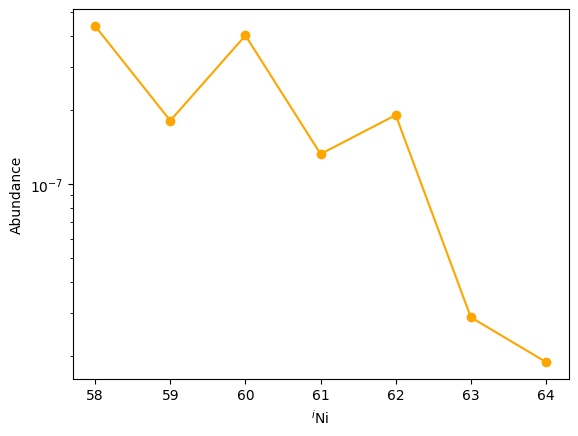

In [51]:
ys_dist = np.dot(Grho, y0_array)
dist_dict = {}
for sp in species:
    dist_dict[sp] = ys_dist[species.index(sp)]
plt.plot(a, ys_dist, '-o', color='orange')
plt.yscale('log')
plt.ylabel('Abundance')
plt.xlabel(r'$^{i}$Ni')
plt.show()